# Process AIRS Spectral OLR to a timeseries for the Arctic

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    plot_trends
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load AIRS data

Nearly 20 years of monthly files, so I will want to subset quickly. I already pre-processed arctic subsets of OLR spectral (clear + all-sky) after averaging over the orbit dimension.

In [2]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'
airsarc_dir = '/glade/work/jonahshaw/obs/AIRS/arc_proc'
# airs_files = glob.glob('%s/L3OLR/**.nc' % airs_dir)
airs_files = glob.glob('%s/proc/**.nc' % airs_dir)

airs_files.sort()
# ceres_file = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-202102.nc'

Load the pre-processed files. Chunk in time because we won't do any operations along that dimension.

In [3]:
airs_solr_file = 'olrspectral_arcticsubset_orbavg.nc'
airs_solr_clear_file = 'olrclrspectral_arcticsubset_orbavg.nc'

airs_solr_ds = xr.open_dataarray('%s/%s' % (airsarc_dir,airs_solr_file),chunks={'lat':-1,'lon':-1,'time':1})
airs_solr_clear_ds = xr.open_dataarray('%s/%s' % (airsarc_dir,airs_solr_clear_file),chunks={'lat':-1,'lon':-1,'time':1})

Now I just want to create timeseries, so I need to apply weights and average over the Central Arctic (70-90N).

In [8]:
# Add weights
airs_solr_wgtd = add_weights(airs_solr_ds)
airs_solr_clear_wgtd = add_weights(airs_solr_clear_ds)

Test xarray built-in weighting versus my function.

In [9]:
# Naive unweighted mean
%time test_wgt1 = airs_solr_wgtd.mean(dim=['lat','lon'])
# Function from Abisko
%time test_wgt2 = masked_average(airs_solr_wgtd,weights=airs_solr_wgtd['cell_weight'],dim=['lat','lon'])
# Xarray built-in weighting results
%time test_wgt3 = airs_solr_wgtd.weighted(airs_solr_wgtd['cell_weight']).mean(dim=['lat','lon'])

CPU times: user 4.79 ms, sys: 0 ns, total: 4.79 ms
Wall time: 16.8 ms
CPU times: user 1.96 s, sys: 342 ms, total: 2.3 s
Wall time: 2.31 s
CPU times: user 23.9 ms, sys: 0 ns, total: 23.9 ms
Wall time: 23.5 ms


Text(0.5, 1.0, 'Percent difference of xarray versus Abisko approaches')

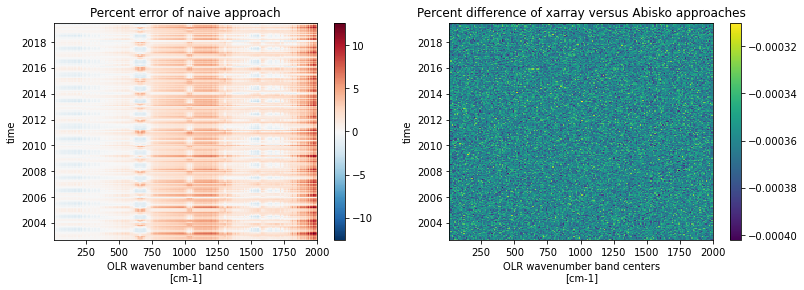

In [10]:
wgttest_fig,wgttest_axs = plt.subplots(1,2,figsize=(13,4))

(100*(test_wgt2 - test_wgt1) / (test_wgt2)).plot(ax=wgttest_axs[0])
wgttest_axs[0].set_title('Percent error of naive approach')

(100*(test_wgt2 - test_wgt3)/(test_wgt2)).plot(ax=wgttest_axs[1])
wgttest_axs[1].set_title('Percent difference of xarray versus Abisko approaches')


Interesting, there is a slight bias between the two weighted approaches... i.e. not centered around zero. Still it's at the last digit so it doesn't matter.

The AIRS SOLR product is empty at the highest latitude bin. This is a bit annoying, but doesn't have a big impact because this region has a very small area.

From here on, I will define the central Arctic as (70 - 87 N) due to the AIRS latitude restriction.

In [11]:
# This interpolation also subsets. Not sure if I care about longitude, but the resolution probably be consistent.
airs_solr_interpd = airs_solr_wgtd.interp(lat=np.arange(70,87.1,1))
airs_solr_clear_interpd = airs_solr_clear_wgtd.interp(lat=np.arange(70,87.1,1))

In [12]:
# Perform spatial weighting to get the tseries.
airs_solr_tseries = airs_solr_interpd.weighted(airs_solr_interpd['cell_weight']).mean(dim=['lat','lon'])
airs_solr_clear_tseries = airs_solr_clear_interpd.weighted(airs_solr_clear_interpd['cell_weight']).mean(dim=['lat','lon'])

In [13]:
# Dechunk to potentially save time while writing to disk
airs_solr_presave = airs_solr_tseries.chunk({'time':-1,'wnum':-1})
airs_solr_clear_presave = airs_solr_clear_tseries.chunk({'time':-1,'wnum':-1})

Create description for attributes.

In [14]:
new_attrs = {}

new_attrs['description'] = '''Processed AIRS L3 spectral OLR data. Averaged out the orbit_pass variable. 
Interpolated to 1deg lat. resolution, subset to 70N-87N and computed an area-weighted average.'''

Add descriptive metadata:

In [15]:
airs_solr_presave.attrs = new_attrs
airs_solr_clear_presave.attrs = new_attrs

Save output.

In [18]:
airs_solr_presave.to_netcdf('%s/olrspectral_70N_87N_wnumtseries.nc' % airsarc_dir)
airs_solr_clear_presave.to_netcdf('%s/olrclrspectral_70N_87N_wnumtseries.nc' % airsarc_dir)

In [86]:
ls $airsarc_dir

olr_broadband.nc                       olrspectral_arcticsubset_orbavg.nc
olrclrspectral_70N_87N_wnumtseries.nc  olr_spectral_trends_lonavg.nc
olrclrspectral_arcticsubset_orbavg.nc  spec_OLR_arcavg.nc
olr_clr_spectral_trends_lonavg.nc      spec_OLRCLR_arcavg.nc
olrspectral_70N_87N_wnumtseries.nc
